### Imports

In [3]:
import sys
import time
import os
from pathlib import Path
import warnings
import requests

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import statsmodels.api as sm
from bs4 import BeautifulSoup


from scipy.stats import linregress
from scipy.signal import cheby1, filtfilt, savgol_filter
from scipy.optimize import curve_fit, minimize


CURRENT_DIR = Path(os.getcwd())


# Move to the root directory


ROOT_DIR = CURRENT_DIR.parents[0]  # Adjust the number based on your folder structure


# Add the root directory to the system path


sys.path.append(str(ROOT_DIR))


# Import the importlib module


import importlib


# import function implementations
import stst_urls


# Reload the modules


importlib.reload(stst_urls)


# Re-import the functions


from stst_urls import GTX_URL

# Input Raw File and Decoder File

In [4]:
wafer_codes = [
    "QCI12",
    "QCI2X",
    "QCI2K",
    "QCI2T",
    "QCI48",
    "QCI2V",
    "QCI0M",
    "QCI46",
    "QCI3L",
]  # List of wafer codes


# Recent Good Wafers (non retest SQL check)
# QCI12
# QCI2X
# QCI2K
# QCI2T
# QCI48
# QCI2V
# QCI0M
# QCI46
# QCI33
# QCI3L
# QCI3E


ANALYSIS_RUN_NAME = "slope_efficiency"
DECODER_FILE = "QC WAFER_LAYOUT 24Dec.csv"
DECODER_FILE_PATH = ROOT_DIR / "decoders" / DECODER_FILE
RESULTS_FILE_PATH = ROOT_DIR / "results"
EXPORTS_FILEPATH = ROOT_DIR / "exports"

# Create the exports folder if it doesn't exist

if not os.path.exists(EXPORTS_FILEPATH):

    os.makedirs(EXPORTS_FILEPATH)

# print(EXPORTS_FILEPATH)

warnings.filterwarnings("ignore")


def liv_raw_filelink_finder(wafer_codes, fileserver_link: str, product_code="QC"):
    fileserver_link = f"{fileserver_link}{product_code}/"
    print(f"fileserver link: {fileserver_link}")

    response = requests.get(fileserver_link, verify=False)
    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    # Map wafer_code to its matching subdirectory link
    subdirectory_map = {}
    for wafer_code in wafer_codes:
        for link in links:
            href = link.get("href")
            if href and wafer_code in href:
                subdirectory_map[wafer_code] = fileserver_link + href
                break  # Only take the first match

    # Output lists
    file_urls = []
    file_cod_urls = []
    file_degradation_urls = []
    file_times = []
    file_cod_times = []
    file_degradation_times = []

    machine_list = []
    machine_dict = {}

    processed_cod70_urls = []
    processed_cod250_urls = []
    processed_cod_base_urls = []

    # Iterate in wafer_codes order
    for wafer_code in wafer_codes:
        subdirectory_url = subdirectory_map.get(wafer_code)
        if not subdirectory_url:
            # Pad with None or blank if no matching folder found
            file_urls.append(None)
            file_cod_urls.append(None)
            file_degradation_urls.append(None)
            file_times.append(None)
            file_cod_times.append(None)
            file_degradation_times.append(None)
            machine_list.append(None)
            machine_dict[wafer_code] = None
            processed_cod70_urls.append(None)
            processed_cod250_urls.append(None)
            processed_cod_base_urls.append(None)
            continue

        response = requests.get(subdirectory_url, verify=False)
        soup = BeautifulSoup(response.content, "html.parser")
        links = soup.find_all("a")

        latest_file = None
        latest_cod_file = None
        latest_degradation_file = None
        latest_time = ""
        latest_cod_time = ""
        latest_degradation_time = ""
        machine_name = None

        proc_cod70 = None
        proc_cod250 = None
        proc_cod_base = None

        for link in links:
            href = link.get("href")
            if not href:
                continue

            # RAW files
            if "RAW" in href:
                time_str = href[-18:-4]

                if not machine_name:
                    machine_name = href[:6]

                if "COD250" in href:
                    if time_str > latest_cod_time:
                        latest_cod_time = time_str
                        latest_cod_file = subdirectory_url + href
                elif "COD70" in href:
                    if time_str > latest_degradation_time:
                        latest_degradation_time = time_str
                        latest_degradation_file = subdirectory_url + href
                else:
                    if time_str > latest_time:
                        latest_time = time_str
                        latest_file = subdirectory_url + href

            # Processed CODs
            elif "processed" in href and "COD" in href:
                full_url = subdirectory_url + href
                if "COD250" in href and proc_cod250 is None:
                    proc_cod250 = full_url
                elif "COD70" in href and proc_cod70 is None:
                    proc_cod70 = full_url
                elif "COD" in href and "COD250" not in href and "COD70" not in href and proc_cod_base is None:
                    proc_cod_base = full_url

        # Append results in order
        file_urls.append(latest_file)
        file_cod_urls.append(latest_cod_file)
        file_degradation_urls.append(latest_degradation_file)
        file_times.append(latest_time)
        file_cod_times.append(latest_cod_time)
        file_degradation_times.append(latest_degradation_time)
        machine_list.append(machine_name)
        machine_dict[wafer_code] = machine_name
        processed_cod70_urls.append(proc_cod70)
        processed_cod250_urls.append(proc_cod250)
        processed_cod_base_urls.append(proc_cod_base)

    return (
        file_urls,
        file_cod_urls,
        file_degradation_urls,
        file_times,
        file_cod_times,
        file_degradation_times,
        machine_list,
        machine_dict,
        processed_cod70_urls,
        processed_cod250_urls,
        processed_cod_base_urls,
    )


# Calling code

(
    file_urls,
    file_cod_urls,
    file_degradation_urls,
    file_times,
    file_cod_times,
    file_degradation_times,
    machine_list,
    machine_dict,
    processed_cod70_urls,
    processed_cod250_urls,
    processed_cod_base_urls,
) = liv_raw_filelink_finder(wafer_codes, GTX_URL, "QC")

print(file_urls)

# DEBUG: INPUT LINKS TO OTHER GTX FILES HERE

# file_urls = [
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250227044906.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250228082707.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250311164324.CSV",
# ]

# print(file_urls)

fileserver link: https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/
['https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI12/LIV_53_QCI12_DNS-LIVTKCOD_LIVTK-DNS_RAW20250319065143.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI2X/LIV_53_QCI2X_DNS-LIVTKCOD_LIVTK-DNS_RAW20250503010911.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI2K/LIV_53_QCI2K_DNS-LIVTKCOD_LIVTK-DNS_RAW20250510213938.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI2T/LIV_54_QCI2T_DNS-LIVTKCOD_LIVTK-DNS_RAW20250428130807.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI48/LIV_53_QCI48_DNS-LIVTKCOD_LIVTK-DNS_RAW20250425223904.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCI2V/LIV_54_QCI2V_DNS-LIVTKCOD_LIVTK-DNS_RAW20250506161304.CSV', 'https://sprgtxprod02.stni.seagate.com/~gtx/waf

# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file
- loops for every csv file chosen, and stores raw_sweep dataframes

In [4]:
def transform_raw_liv_file(file_url, decoder_file_path, machine_code, wafer_id):
    start_time = time.time()

    # Step 1: Read the CSV file from the URL, skipping the first 19 rows
    print("Step 1: Reading the CSV file...")
    df = pd.read_csv(
        file_url,
        skiprows=19,
    )
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 15: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    return df_raw_sweeps


def transform_raw_liv_file_first_n_rows(file_url, decoder_file_path, machine_code, wafer_id, n):
    start_time_overall = time.time()

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    start_time = time.time()
    df = pd.read_csv(file_url, skiprows=19, nrows=n)
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    start_time = time.time()
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 15: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    sampling_rate = 1

    return (df_raw_sweeps, n_meas, n_devices, sampling_rate)


def transform_raw_liv_file_every_nth_laser(file_url, decoder_file_path, machine_code, wafer_id, n=10000):
    start_time_overall = time.time()

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    start_time = time.time()
    df = pd.read_csv(file_url, skiprows=19)
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Filter every nth laser based on TOUCHDOWN
    print(f"Step 3: Filtering every {n}th laser...")
    start_time = time.time()
    df_filtered = df[df["TOUCHDOWN"] % n == 0]
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Get column names and subset the data frame with selected columns
    print("Step 4: Subsetting the data frame...")
    start_time = time.time()
    col_names = df_filtered.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df_filtered[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Transpose the data frame and reset index
    print("Step 5: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Split transposed table into Vf and PD data tables
    print("Step 6: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Learn data dimensions
    print("Step 7: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all Voltage columns into one
    print("Step 8: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    # Instead of generating a new TOUCHDOWN, reuse the one from df_filtered
    df_concat_vf["TOUCHDOWN"] = df_filtered["TOUCHDOWN"].repeat(n_meas).values
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Concatenate all PD columns into one
    print("Step 9: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Cartesian join of Vf and PD data tables
    print("Step 10: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Add device coordinates from original RAW file
    print("Step 11: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Merge with decoder file to get TE_LABEL etc.
    print("Step 12: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Rename the columns
    print("Step 13: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add current column as a repeating sequence of length n_meas
    print("Step 14: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 15: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    # Step 16: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 16: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 16 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    sampling_rate = n

    return (df_raw_sweeps, n_meas, n_devices, sampling_rate)


raw_sweeps_tables = []
device_numbers = []
sampling_rates = []

warnings.filterwarnings("ignore")

ROW_NUMBER = 1000

# # CAL
# for file_url, machine_code in zip(file_urls, machine_list):
#     df_raw_sweeps, n_meas, n_devices = transform_raw_liv_file_first_n_rows(file_url, DECODER_FILE_PATH, machine_code, ROW_NUMBER)
#     if df_raw_sweeps["TE_LABEL"].isna().any():
#         raise ValueError("ERROR: Decoder Matching Failed! Perhaps the wrong decoder file was used, no matching X or Y coords found")
#     raw_sweeps_tables.append(df_raw_sweeps)
#     device_numbers.append(n_devices)

# # Display the first 10 rows of the raw_sweeps table
# print(raw_sweeps_tables[0].head(10))
# print(device_numbers[0])

# DEBUG: CALLING SAMPLED DATA ACROSS MULTIPLE WAFERS
SAMPLE_ROWS = 10000  # You can change this value to any other number as needed
for file_url, machine_code, wafer_code in zip(file_urls, machine_list, wafer_codes):
    df_raw_sweeps, n_meas, n_devices, sampling_rate = transform_raw_liv_file_every_nth_laser(
        file_url, DECODER_FILE_PATH, machine_code, wafer_code, n=SAMPLE_ROWS
    )
    if df_raw_sweeps["TE_LABEL"].isna().any():
        raise ValueError(
            "ERROR: Decoder Matching Failed! Perhaps the wrong decoder file was used, no matching X or Y coords found"
        )
    raw_sweeps_tables.append(df_raw_sweeps)
    device_numbers.append(n_devices)
    sampling_rates.append(sampling_rate)

# # Concatenate all dataframes together
# df_combined = pd.concat(raw_sweeps_tables, ignore_index=True)
# # easy measure to make rest of code call:
# raw_sweeps_tables = [df_combined]

# # Display the first 10 rows of the combined dataframe
# print(df_combined.head(10))
# print(raw_sweeps_tables[0].head(10))

Step 2: Reading the data rows, skipping the header rows...
Step 2 completed in 10.59 seconds
Step 3: Filtering every 10000th laser...
Step 3 completed in 0.02 seconds
Step 4: Subsetting the data frame...
Step 4 completed in 0.01 seconds
Step 5: Transposing the data frame...
Step 5 completed in 0.01 seconds
Step 6: Splitting the transposed table...
Step 6 completed in 0.01 seconds
Step 7: Learning data dimensions...
Number of Current Measurements per Device: 63
Number of Devices: 34
Step 7 completed in 0.00 seconds
Step 8: Concatenating Voltage columns...
Step 8 completed in 0.00 seconds
Step 9: Concatenating PD columns...
Step 9 completed in 0.00 seconds
Step 10: Performing Cartesian join...
Step 10 completed in 0.00 seconds
Step 11: Adding device coordinates...
Step 11 completed in 0.02 seconds
Step 12: Merging with decoder file...
Step 12 completed in 1.17 seconds
Step 13: Renaming columns...
Step 13 completed in 0.00 seconds
Step 14: Adding current column...
Step 14 completed in 0.0

# General Processing Functions

Some predefined functions that can be used outside of ITH

In [9]:
def basic_sweep_analysis(df):
    """
    Compute first and second order differentials for voltage (Vf) and photodiode signal (PD)
    while ensuring calculations remain per device.
    Additionally, compute min and max PD per touchdown and clone max PD across the sweep.
    """
    df["dV/dI"] = df.groupby("TOUCHDOWN")["Vf"].diff()
    df["dP/dI"] = df.groupby("TOUCHDOWN")["PD"].diff()
    df["d2V/dI2"] = df.groupby("TOUCHDOWN")["dV/dI"].diff()
    df["d2P/dI2"] = df.groupby("TOUCHDOWN")["dP/dI"].diff()

    df["MAX_PD"] = df.groupby("TOUCHDOWN")["PD"].transform("max")
    df["MIN_PD"] = df.groupby("TOUCHDOWN")["PD"].transform("min")
    return df


def flag_no_laser_touchdowns(df_raw_sweeps):
    """
    Adds a "FLAG" column to df_raw_sweeps, labeling touchdowns as "NO LASER"
    if the max PD value for that touchdown is below 1.
    """
    df_raw_sweeps["FLAG"] = np.nan
    no_laser_touchdowns = df_raw_sweeps.groupby("TOUCHDOWN")["PD"].max()
    no_laser_touchdowns = no_laser_touchdowns[no_laser_touchdowns < 1].index
    df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"].isin(no_laser_touchdowns), "FLAG"] = "NO LASER"
    return df_raw_sweeps


# Linear model for line fitting
def linear_model(x, slope, intercept):
    return slope * x + intercept


# Least Absolute Residuals fitting function using L1 norm
def least_absolute_residuals_fit(x, y, model, initial_guess, bounds):
    def objective(params):
        return np.sum(np.abs(model(x, *params) - y))

    result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B", options={"maxiter": 1000})

    residuals = np.abs(model(x, *result.x) - y)
    mean_abs_error = np.mean(residuals)

    return result.x, mean_abs_error

# I_th Processing Functions

- Has a function that finds ith given an input intensity and current array
    - **NB:** find_ith_value_labview is trying to mimic labview more closely, while the find_ith_value is a custom function that finds ith value using a similar but not identical mechanisim
- Calls the find_ith_value function on the multiple lasers in the raw sweep file with evaluate_ITH_on_rawsweep
- Then generates a device level summary using generate_ITH_device_summary_table
- calls this code and exports in the main for loop.

In [10]:
def find_ith_value(intensity, current, min_slope_fitpnt=1, max_slope_fitpnt=10, window_length=5, polyorder=2):
    try:
        # Sort data by current to ensure proper processing
        sorted_indices = np.argsort(current)
        current, intensity = current[sorted_indices], intensity[sorted_indices]

        # Normalize intensity using provided max and min PD values
        min_intensity, max_intensity = np.min(intensity), np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Normalize intensity using min-max scaling
        min_intensity = np.min(intensity)
        max_intensity = np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Apply Savitzky-Golay smoothing to normalized intensity
        smoothed_intensity_norm = savgol_filter(intensity_norm, window_length=window_length, polyorder=polyorder)

        # Compute differentials on normalized & smoothed data
        smoothed_dI_dC_norm = np.gradient(smoothed_intensity_norm, current)
        smoothed_d2I_dC2_norm = np.gradient(smoothed_dI_dC_norm, current)

        # Filter the data to only consider LDI between 2 and 30 mA for Gaussian fitting
        mask = (current >= 2) & (current <= 30)
        if not np.any(mask):
            print("Warning: No data points in the 2-30 mA range.")
            return None

        current_masked = current[mask]
        smoothed_d2I_dC2_norm_masked = smoothed_d2I_dC2_norm[mask]

        # Fit Gaussian to the smoothed second differential
        p0 = [np.max(smoothed_d2I_dC2_norm_masked), np.median(current_masked), np.std(current_masked)]
        popt, pcov = curve_fit(gaussian, current_masked, smoothed_d2I_dC2_norm_masked, p0=p0)
        median_x = popt[1]  # Extract median x from Gaussian fit

        # Handle fitting errors
        if not (2 <= median_x <= 30):
            print("Warning: Gaussian fit unable to find reasonable split point. ")
            median_x = 12.5
        elif np.any(np.diag(pcov) > 0.1):  # Adjust threshold as needed
            print("Warning: Abnormal LI curve detected due to high error in Gaussian fit.")
            return None

        # Split data at median_x
        left_side = current[current <= median_x]
        right_side_mask = (current > median_x + min_slope_fitpnt) & (
            current < median_x + max_slope_fitpnt
        )  # Only Fit Right Slope after a few current pnts after ITH, and up to a certain current maximum above ITH.
        right_side = current[right_side_mask]
        intensity_norm_left = intensity_norm[current <= median_x]
        intensity_norm_right = intensity_norm[right_side_mask]

        # Check if either side is empty
        if len(left_side) == 0 or len(right_side) == 0:
            print("Warning: No reasonable I_th detected within bounds.")
            return None

        # Fit linear regression to both segments
        slope_left, intercept_left, _, _, _ = linregress(left_side, intensity_norm_left)
        slope_right, intercept_right, _, _, _ = linregress(right_side, intensity_norm_right)

        # Compute intersection point
        intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
        ith_value = intersection_x  # No rounding

        # Final evaluation check for ITH value
        if not (2 <= ith_value <= 30):
            print("Warning: Computed ITH value outside valid bounds (2-30 mA). Returning None.")
            return None

        return ith_value
    except Exception as e:
        print(f"Error: {e}")
        return None


# Gaussian model for fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def find_ith_value_labview(intensity, current):
    # try:
    # 1) Trim data to only include values >2 and <=35 mA
    mask_trimmed = (current > 1) & (current <= 34)
    if not np.any(mask_trimmed):
        print("Warning: No data points between 2 and 35 mA.")
        return 0
    current = current[mask_trimmed]
    intensity = intensity[mask_trimmed]

    # 2) Interpolate to double resolution (spacing of 0.5 mA)
    current_interp = np.arange(np.min(current), np.max(current) + 0.1, 0.5)
    intensity_interp = np.interp(current_interp, current, intensity)

    current = current_interp
    intensity = intensity_interp

    # 3) Normalize intensity using min-max scaling (first operation)
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

    # 4) Sort data by current to ensure proper processing
    sorted_indices = np.argsort(current)
    current = current[sorted_indices]
    intensity_norm = intensity_norm[sorted_indices]

    # 5) Apply Chebyshev high-pass filter (order 2, ripple 0.1 dB, bandpass 0.15–0.45)
    b, a = cheby1(N=2, rp=0.1, Wn=[0.15, 0.45], btype="bandpass", fs=1)
    filtered_intensity = filtfilt(b, a, intensity_norm)

    # 5a) Initial linear fit via least absolute residuals on filtered data using QuantReg
    X = sm.add_constant(current)  # Adds intercept term
    model = sm.QuantReg(filtered_intensity, X)
    res = model.fit(q=0.5)
    slope_left = res.params[1]
    intercept_left = res.params[0]
    initial_abs_residual_total = np.mean(np.abs(filtered_intensity - res.predict(X)))

    # print(initial_abs_residual_total)
    if initial_abs_residual_total > 0.001:
        print("Warning: Initial L1 fit residual too high.")
        return 0

    # 6) First Savitzky-Golay smoothing (5,1)
    smoothed_intensity = savgol_filter(filtered_intensity, window_length=5, polyorder=1)

    # 7) Second Savitzky-Golay smoothing before differential (3,2)
    smoothed_intensity = savgol_filter(smoothed_intensity, window_length=3, polyorder=2)

    # 8) Compute first derivative (renamed to dL_dI)
    dL_dI = np.gradient(smoothed_intensity, current)

    # 9) Smooth first derivative (6,2)
    smoothed_dL_dI = savgol_filter(dL_dI, window_length=6, polyorder=2)

    # 10) Compute second derivative (renamed to d2L_dI2)
    d2L_dI2 = np.gradient(smoothed_dL_dI, current)

    # 11) Smooth second derivative (6,2)
    smoothed_d2L_dI2 = savgol_filter(d2L_dI2, window_length=6, polyorder=2)

    # 11a) Set negative second derivative values to zero (LabVIEW-like behavior)
    smoothed_d2L_dI2[smoothed_d2L_dI2 < 0] = 0

    # 12) Normalize second derivative and add 0.01
    max_d2L_dI2 = np.max(smoothed_d2L_dI2)
    if max_d2L_dI2 == 0:
        print("Warning: Second derivative all zero after zeroing negatives.")
        return 0
    d2L_dI2_ready = (smoothed_d2L_dI2 / max_d2L_dI2) + 0.01

    # 13) Least Absolute Residuals fitting with initial conditions and bounds
    initial_guess = [1, 11, np.std(current)]
    bounds = [
        (0, np.inf),  # Bounds for parameter a
        (7, np.max(current) - 3),  # Bounds for parameter x0
        (0, 3),  # Bounds for parameter sigma
    ]
    popt, _ = least_absolute_residuals_fit(current, d2L_dI2_ready, gaussian, initial_guess, bounds)
    median_x = popt[1]

    # 14) Validate split point
    if not (2 <= median_x <= 35):
        print("Warning: Gaussian fit split point out of bounds. Using default 12.5 mA.")
        median_x = 12.5

    # 15) Linear fitting on left segment (with gradient bound)
    left_mask = current <= median_x
    if not np.any(left_mask):
        print("Warning: No data points on the left segment for fitting.")
        return 0

    current_left = current[left_mask]
    intensity_left = intensity_norm[left_mask]

    popt_left, _ = curve_fit(linear_model, current_left, intensity_left, bounds=([0.001, -np.inf], [np.inf, np.inf]))
    slope_left, intercept_left = popt_left

    # 16) Linear fitting on right segment (no bounds)
    right_mask = current > median_x
    if not np.any(right_mask):
        print("Warning: No data points on the right segment for fitting.")
        return 0

    current_right = current[right_mask]
    intensity_right = intensity_norm[right_mask]

    if len(current_right) < 10:
        print("Warning: Fewer than 10 data points for stimulated emission fit.")
        return 0

    popt_right, _ = curve_fit(linear_model, current_right, intensity_right)
    slope_efficiency, intercept_right = popt_right

    fitted_right = linear_model(current_right, *popt_right)
    mse_right = np.mean((intensity_right - fitted_right) ** 2)

    # print(mse_right)
    if mse_right > 0.001:
        print("Warning: High MSE in stimulated emission fit.")
        return 0

    # 17) Compute intersection (I_th)
    ith_value = (intercept_right - intercept_left) / (slope_left - slope_efficiency)
    if not (2 <= ith_value <= 35):
        print("Warning: Computed I_th outside bounds. Returning None.")
        return 0

    return ith_value

# SE Processing Functions

- Function that finds ith given an input intensity and current array
- takes intensity and current for a laser as an input, and masks the arrays based on the 15 points above ITH
- Fits a line to the points using least squares regression (performant vectorised matrix alogithms) and returns the gradient

In [11]:
def find_slope_efficiency(intensity, current, ith, mse_threshold=0.05):
    intensity = np.asarray(intensity)
    current = np.asarray(current)

    if len(intensity) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + 15

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for slope efficiency fit.")
        return 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = intensity[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution

        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in slope efficiency fit ({mse:.4f}).")
                return 0

        return slope

    except Exception as e:
        print(f"Error during slope efficiency calculation: {e}")
        return 0

# Calling Code

In [12]:
def evaluate_lasing_parameters_on_rawsweep(df_raw_sweeps, touchdown_number, sampling_rate=1):
    df_raw_sweeps["ITH"] = np.nan
    df_raw_sweeps["SLOPE_EFFICIENCY"] = np.nan

    for touchdown in range(sampling_rate, touchdown_number * sampling_rate + 1, sampling_rate):
        specific_data = df_raw_sweeps[df_raw_sweeps["TOUCHDOWN"] == touchdown]
        if not specific_data.empty and "NO LASER" not in specific_data["FLAG"].values:
            intensity = specific_data["PD"].values
            current = specific_data["LDI_mA"].values

            ith_value = find_ith_value_labview(intensity, current)
            if ith_value != 0:
                slope_eff = find_slope_efficiency(intensity, current, ith_value)

                df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "ITH"] = ith_value

                if slope_eff is not None:
                    df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "SLOPE_EFFICIENCY"] = slope_eff

    return df_raw_sweeps


def generate_lasing_device_summary_table(raw_sweeps):
    device_summary = (
        raw_sweeps.groupby("TE_LABEL")
        .agg(
            {
                "WAFER_ID": "first",
                "MACH": "first",
                "TOUCHDOWN": "first",
                "ITH": "first",
                "SLOPE_EFFICIENCY": "first",
                "TYPE": "first",
                "X_UM": "first",
                "Y_UM": "first",
                "FLAG": "first",
            }
        )
        .reset_index()
        .sort_values("TOUCHDOWN")
    )

    return device_summary


annotated_sweeps_tables = []


device_summary_tables = []


wafer_summary_tables = []


for df_raw_sweeps, num_devices, sampling_rate, wafer_code in zip(
    raw_sweeps_tables, device_numbers, sampling_rates, wafer_codes
):
    # Apply the NO LASER flag function
    df_raw_sweeps = flag_no_laser_touchdowns(df_raw_sweeps)
    # print(f"\nflagged:\n {df_raw_sweeps}")

    # Run ITH evaluations
    df_raw_sweeps = evaluate_lasing_parameters_on_rawsweep(df_raw_sweeps, num_devices, sampling_rate)
    # print(f"\nannotated:\n {df_raw_sweeps}")
    annotated_sweeps_tables.append(df_raw_sweeps)
    # df_raw_sweeps.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_raw_sweeps.csv", index=False)

    # Device Summary
    device_summary = generate_lasing_device_summary_table(df_raw_sweeps)
    # print(f"\ndevice summary:\n {device_summary}")
    device_summary_tables.append(device_summary)
    device_summary.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_device_summary.csv", index=False)

# print(annotated_sweeps_tables[0].head(1000))

# print(device_summary_tables[0].head(1000))
# print(len(device_summary_tables))

# Concatenate all dataframes together
df_combined = pd.concat(device_summary_tables, ignore_index=True)
df_combined.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_device_combined_summary.csv", index=False)

# Display the first 10 rows of the combined dataframe
# print(df_combined.head(10))

# Debugging

In [27]:
# Gaussian model for fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


# Linear model for line fitting
def linear_model(x, slope, intercept):
    return slope * x + intercept


# Least Absolute Residuals fitting function using L1 norm
def least_absolute_residuals_fit(x, y, model, initial_guess, bounds):
    def objective(params):
        return np.sum(np.abs(model(x, *params) - y))

    result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B", options={"maxiter": 1000})

    residuals = np.abs(model(x, *result.x) - y)
    mean_abs_error = np.mean(residuals)

    return result.x, mean_abs_error


def find_ith_value(intensity, current, min_slope_fitpnt=1, max_slope_fitpnt=15, window_length=5, polyorder=2):
    try:
        # Sort data by current to ensure proper processing
        sorted_indices = np.argsort(current)
        current, intensity = current[sorted_indices], intensity[sorted_indices]

        # Normalize intensity using provided max and min PD values
        min_intensity, max_intensity = np.min(intensity), np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Normalize intensity using min-max scaling
        min_intensity = np.min(intensity)
        max_intensity = np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Apply Savitzky-Golay smoothing to normalized intensity
        smoothed_intensity_norm = savgol_filter(intensity_norm, window_length=window_length, polyorder=polyorder)

        # Compute differentials on normalized & smoothed data
        smoothed_dI_dC_norm = np.gradient(smoothed_intensity_norm, current)
        smoothed_d2I_dC2_norm = np.gradient(smoothed_dI_dC_norm, current)

        # Filter the data to only consider LDI between 2 and 30 mA for Gaussian fitting
        mask = (current >= 2) & (current <= 30)
        if not np.any(mask):
            print("Warning: No data points in the 2-30 mA range.")
            return None

        current_masked = current[mask]
        smoothed_d2I_dC2_norm_masked = smoothed_d2I_dC2_norm[mask]

        # Fit Gaussian to the smoothed second differential
        p0 = [np.max(smoothed_d2I_dC2_norm_masked), np.median(current_masked), np.std(current_masked)]
        popt, pcov = curve_fit(gaussian, current_masked, smoothed_d2I_dC2_norm_masked, p0=p0)
        median_x = popt[1]  # Extract median x from Gaussian fit

        # Handle fitting errors
        if not (2 <= median_x <= 30):
            print("Warning: Gaussian fit unable to find reasonable split point. ")
            median_x = 12.5
        elif np.any(np.diag(pcov) > 0.1):  # Adjust threshold as needed
            print("Warning: Abnormal LI curve detected due to high error in Gaussian fit.")
            return None

        # Split data at median_x
        left_side = current[current <= median_x]
        right_side_mask = (current > median_x + min_slope_fitpnt) & (
            current < median_x + max_slope_fitpnt
        )  # Only Fit Right Slope after a few current pnts after ITH, and up to a certain current maximum above ITH.
        right_side = current[right_side_mask]
        intensity_norm_left = intensity_norm[current <= median_x]
        intensity_norm_right = intensity_norm[right_side_mask]

        # Check if either side is empty
        if len(left_side) == 0 or len(right_side) == 0:
            print("Warning: No reasonable I_th detected within bounds.")
            return None

        # Fit linear regression to both segments
        slope_left, intercept_left, _, _, _ = linregress(left_side, intensity_norm_left)
        slope_right, intercept_right, _, _, _ = linregress(right_side, intensity_norm_right)

        # Compute intersection point
        intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
        ith_value = intersection_x  # No rounding

        # Final evaluation check for ITH value
        if not (2 <= ith_value <= 30):
            print("Warning: Computed ITH value outside valid bounds (2-30 mA). Returning None.")
            return None

        return ith_value
    except Exception as e:
        print(f"Error: {e}")
        return None


def find_ith_value_labview_debug(intensity, current):
    # 1) Trim data to only include values >2 and <=35 mA
    mask_trimmed = (current > 1) & (current <= 34)
    if not np.any(mask_trimmed):
        print("Warning: No data points between 2 and 35 mA.")
        return 0
    current = current[mask_trimmed]
    intensity = intensity[mask_trimmed]
    print("\n[Stage 1] After trimming to 2–35 mA:")
    print("Current (mA):", current)
    print("Intensity (W):", intensity)
    plt.figure()
    plt.plot(current, intensity, "bo-")
    plt.title("Stage 1: Trimmed Data")
    plt.xlabel("Current (mA)")
    plt.ylabel("Intensity (W)")
    plt.grid()

    # 2) Interpolate to double resolution (spacing of 0.5 mA)
    current_interp = np.arange(np.min(current), np.max(current) + 0.1, 0.5)
    intensity_interp = np.interp(current_interp, current, intensity)
    current = current_interp
    intensity = intensity_interp
    print("\n[Stage 2] After interpolation to 0.5 mA resolution:")
    print("Current (mA):", current)
    print("Intensity (W):", intensity)
    plt.figure()
    plt.plot(current, intensity, "go-")
    plt.title("Stage 2: Interpolated Data")
    plt.xlabel("Current (mA)")
    plt.ylabel("Intensity (W)")
    plt.grid()

    # 3) Normalize intensity using min-max scaling
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)
    print("\n[Stage 3] After intensity normalization (min-max):")
    print("Intensity (normalized):", intensity_norm)
    plt.figure()
    plt.plot(current, intensity_norm, "ro-")
    plt.title("Stage 3: Normalized Intensity")
    plt.xlabel("Current (mA)")
    plt.ylabel("Normalized Intensity")
    plt.grid()

    # 4) Sort data by current
    sorted_indices = np.argsort(current)
    current = current[sorted_indices]
    intensity_norm = intensity_norm[sorted_indices]
    print("\n[Stage 4] After sorting by current:")
    print("Current (mA):", current)
    print("Intensity (normalized):", intensity_norm)

    # 5) Apply Chebyshev bandpass filter
    b, a = cheby1(N=2, rp=0.1, Wn=[0.15, 0.45], btype="bandpass", fs=1)
    filtered_intensity = filtfilt(b, a, intensity_norm)
    # filtered_intensity = intensity_norm  # DEBUG: remove chebyshev filter
    print("\n[Stage 5] After Chebyshev bandpass filter:")
    print("Filtered Intensity:", filtered_intensity)
    plt.figure()
    plt.plot(current, filtered_intensity, "c-")
    plt.title("Stage 5: Chebyshev Filtered Intensity")
    plt.xlabel("Current (mA)")
    plt.ylabel("Filtered Intensity")
    plt.grid()

    # 5a) Initial L1 fit
    X = sm.add_constant(current)
    model = sm.QuantReg(filtered_intensity, X)
    res = model.fit(q=0.5)
    slope_left = res.params[1]
    intercept_left = res.params[0]
    initial_abs_residual_total = np.mean(np.abs(filtered_intensity - res.predict(X)))
    print("\n[Stage 5a] Initial L1 Fit:")
    print(f"Slope: {slope_left}, Intercept: {intercept_left}, Mean Absolute Residual: {initial_abs_residual_total}")
    plt.figure()
    plt.plot(current, filtered_intensity, "b.", label="Filtered")
    plt.plot(current, res.predict(X), "k--", label="L1 Fit")
    plt.title("Stage 5a: L1 Fit")
    plt.xlabel("Current (mA)")
    plt.ylabel("Intensity")
    plt.legend()
    plt.grid()

    if initial_abs_residual_total > 100:  # DEBUG: DISABLE L1 FIT CHECK: set to 100 no 0.001
        print("Warning: Initial L1 fit residual too high.")
        return 0

    # 6–7) Savitzky-Golay smoothing
    smoothed_intensity = savgol_filter(filtered_intensity, window_length=5, polyorder=1)
    smoothed_intensity = savgol_filter(smoothed_intensity, window_length=3, polyorder=2)
    print("\n[Stage 6–7] After Savitzky-Golay smoothing:")
    print("Smoothed Intensity:", smoothed_intensity)
    plt.figure()
    plt.plot(current, smoothed_intensity, "m-")
    plt.title("Stage 6–7: Smoothed Intensity")
    plt.xlabel("Current (mA)")
    plt.ylabel("Smoothed Intensity")
    plt.grid()

    # 8–11a) Derivatives and smoothing
    dL_dI = np.gradient(smoothed_intensity, current)
    smoothed_dL_dI = savgol_filter(dL_dI, window_length=6, polyorder=2)
    d2L_dI2 = np.gradient(smoothed_dL_dI, current)
    smoothed_d2L_dI2 = savgol_filter(d2L_dI2, window_length=6, polyorder=2)
    smoothed_d2L_dI2[smoothed_d2L_dI2 < 0] = 0
    print("\n[Stage 11] Second derivative (after zeroing negatives):")
    print("Smoothed d²L/dI²:", smoothed_d2L_dI2)
    plt.figure()
    plt.plot(current, smoothed_d2L_dI2, "r-")
    plt.title("Stage 11: Smoothed d²L/dI² (≥0)")
    plt.xlabel("Current (mA)")
    plt.ylabel("d²L/dI²")
    plt.grid()

    # 12) Normalize second derivative
    max_d2L_dI2 = np.max(smoothed_d2L_dI2)
    if max_d2L_dI2 == 0:
        print("Warning: Second derivative all zero after zeroing negatives.")
        return 0
    d2L_dI2_ready = (smoothed_d2L_dI2 / max_d2L_dI2) + 0.01
    print("\n[Stage 12] Normalized and offset second derivative:")
    print("d²L/dI² Ready:", d2L_dI2_ready)

    # 13) Gaussian fit
    # initial_guess = [1, 11, np.std(current)]
    # DEBUG ADJUSTMENT
    initial_guess = [1, 11, np.std(current)]  # DEBUG ADJUSTMENT
    bounds = [(0.9, np.inf), (7, np.max(current) - 3), (0.5, 3)]
    popt, _ = least_absolute_residuals_fit(current, d2L_dI2_ready, gaussian, initial_guess, bounds)
    a_gauss, median_x, sigma_gauss = popt
    print("\n[Stage 13] Gaussian fit on second derivative:")
    print(f"a: {a_gauss}, x0 (median_x): {median_x}, sigma: {sigma_gauss}")
    plt.figure()
    plt.plot(current, d2L_dI2_ready, "g.", label="Data")
    plt.plot(current, gaussian(current, *popt), "k--", label="Gaussian Fit")
    plt.title("Stage 13: Gaussian Fit on d²L/dI²")
    plt.xlabel("Current (mA)")
    plt.ylabel("d²L/dI² Ready")
    plt.legend()
    plt.grid()

    if not (2 <= median_x <= 35):
        print("Warning: Gaussian fit split point out of bounds. Using default 12.5 mA.")
        median_x = 12.5

    # 15) Linear fit on left segment
    left_mask = current <= median_x
    if not np.any(left_mask):
        print("Warning: No data points on the left segment for fitting.")
        return 0
    current_left = current[left_mask]
    intensity_left = intensity_norm[left_mask]
    popt_left, _ = curve_fit(linear_model, current_left, intensity_left, bounds=([0.001, -np.inf], [np.inf, np.inf]))
    slope_left, intercept_left = popt_left
    print("\n[Stage 15] Linear fit on left segment:")
    print(f"Slope: {slope_left}, Intercept: {intercept_left}")
    plt.figure()
    plt.plot(current_left, intensity_left, "b.", label="Left Data")
    plt.plot(current_left, linear_model(current_left, *popt_left), "r--", label="Left Fit")
    plt.title("Stage 15: Linear Fit (Left)")
    plt.xlabel("Current (mA)")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid()

    # 16) Linear fit on right segment
    right_mask = current > median_x
    if not np.any(right_mask):
        print("Warning: No data points on the right segment for fitting.")
        return 0
    current_right = current[right_mask]
    intensity_right = intensity_norm[right_mask]
    if len(current_right) < 10:
        print("Warning: Fewer than 10 data points for stimulated emission fit.")
        return 0
    popt_right, _ = curve_fit(linear_model, current_right, intensity_right)
    slope_efficiency, intercept_right = popt_right
    print("\n[Stage 16] Linear fit on right segment (stimulated emission):")
    print(f"Slope: {slope_efficiency}, Intercept: {intercept_right}")
    fitted_right = linear_model(current_right, *popt_right)
    plt.figure()
    plt.plot(current_right, intensity_right, "g.", label="Right Data")
    plt.plot(current_right, fitted_right, "m--", label="Right Fit")
    plt.title("Stage 16: Linear Fit (Right)")
    plt.xlabel("Current (mA)")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid()

    mse_right = np.mean((intensity_right - fitted_right) ** 2)
    if mse_right > 100:
        print("Warning: High MSE in stimulated emission fit.")
        return 0

    # 17) Compute intersection (I_th)
    ith_value = (intercept_right - intercept_left) / (slope_left - slope_efficiency)
    if not (2 <= ith_value <= 35):
        print("Warning: Computed I_th outside bounds. Returning None.")
        return 0

    print(f"\n[Stage 17] Computed I_th: {ith_value:.3f} mA")
    plt.figure()
    plt.plot(current, intensity_norm, label="Normalized Intensity")
    plt.plot(current_left, linear_model(current_left, *popt_left), "r--", label="Left Fit")
    plt.plot(current_right, fitted_right, "g--", label="Right Fit")
    plt.axvline(ith_value, color="k", linestyle=":", label=f"I_th = {ith_value:.2f} mA")
    plt.title("Stage 17: Threshold Current I_th")
    plt.xlabel("Current (mA)")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid()

    return ith_value

🔍 Reading sample raw LI data from CSV...

[Stage 1] After trimming to 2–35 mA:
Current (mA): [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
Intensity (W): [0.00015711 0.0001667  0.00017662 0.00018559 0.00019397 0.00019596
 0.00020938 0.00021268 0.00022457 0.00024137 0.00026275 0.00028294
 0.00031356 0.00035197 0.00060974 0.00162949 0.00267196 0.00369855
 0.00468799 0.00566214 0.006629   0.00759104 0.00855023 0.00950567
 0.01044474 0.01138646 0.01232981 0.01327485 0.0142238  0.01517716
 0.01612273 0.01706368 0.01800067]

[Stage 2] After interpolation to 0.5 mA resolution:
Current (mA): [ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5
 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  

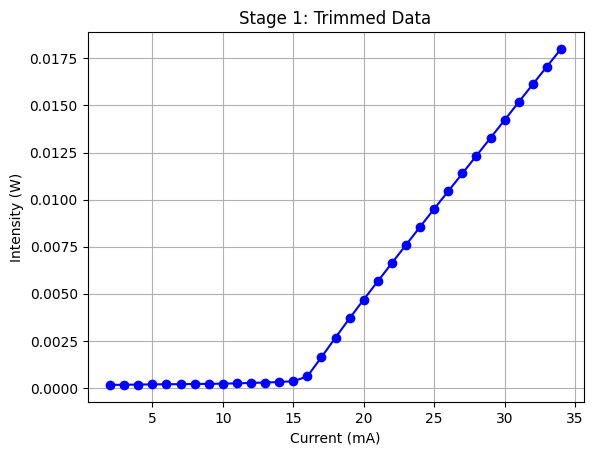

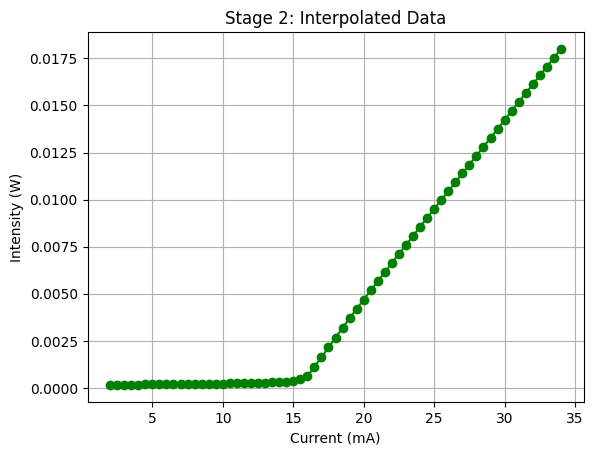

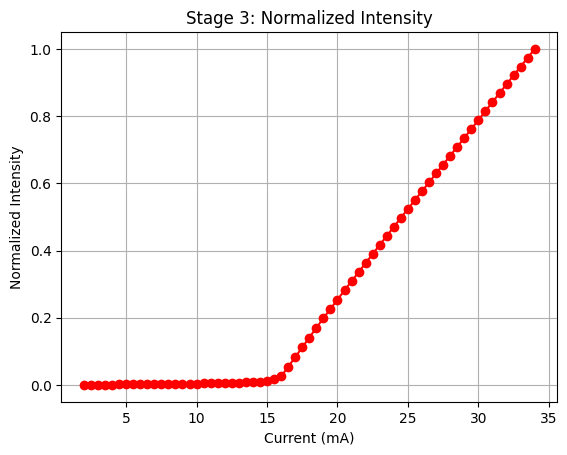

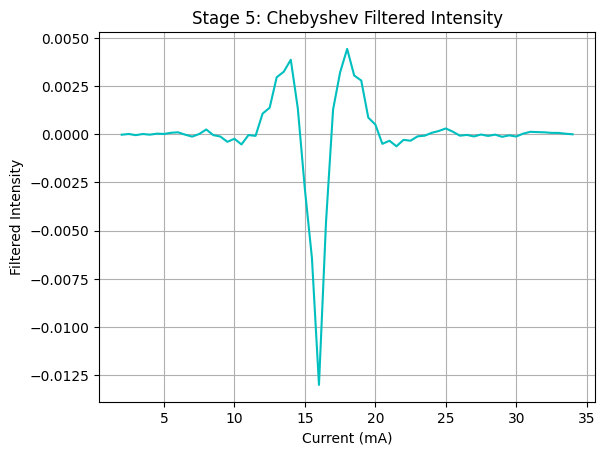

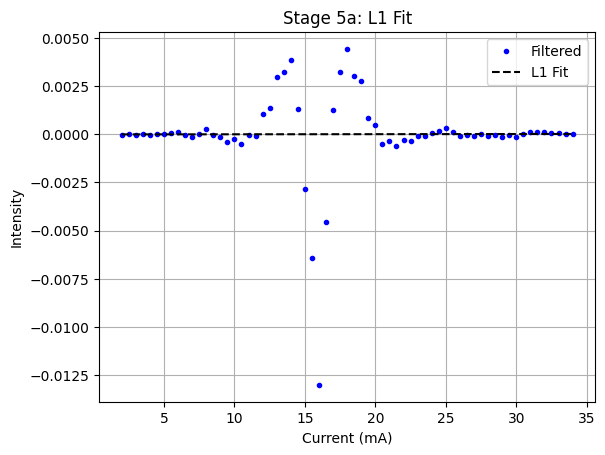

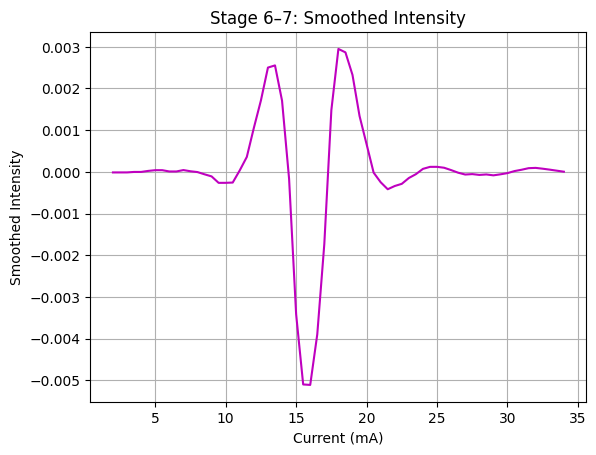

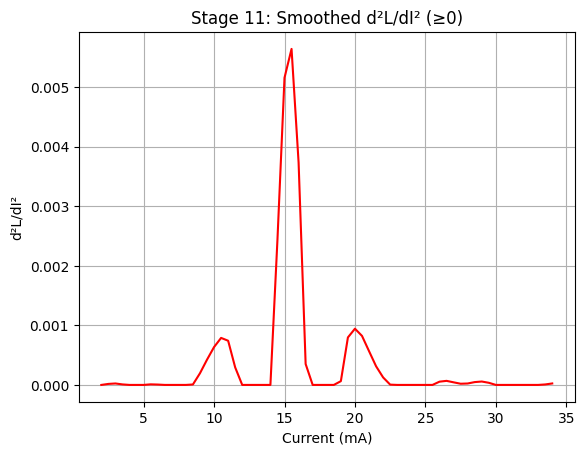

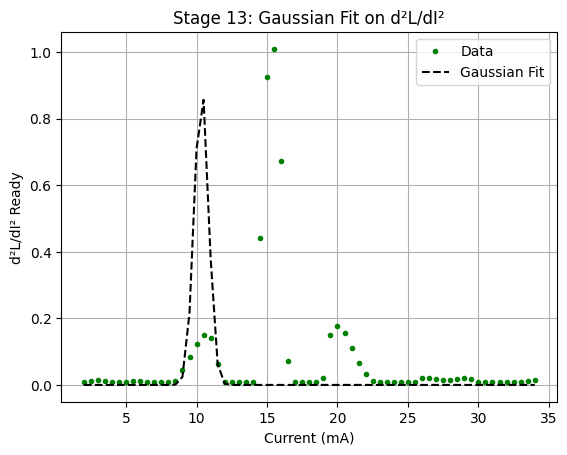

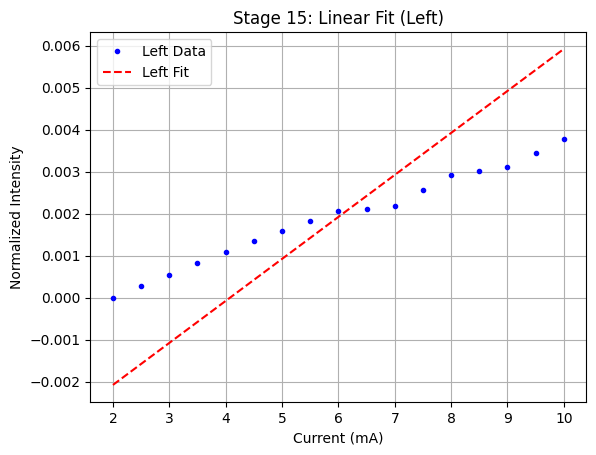

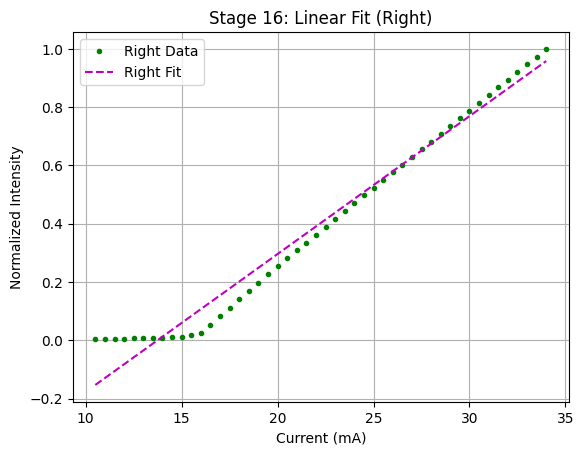

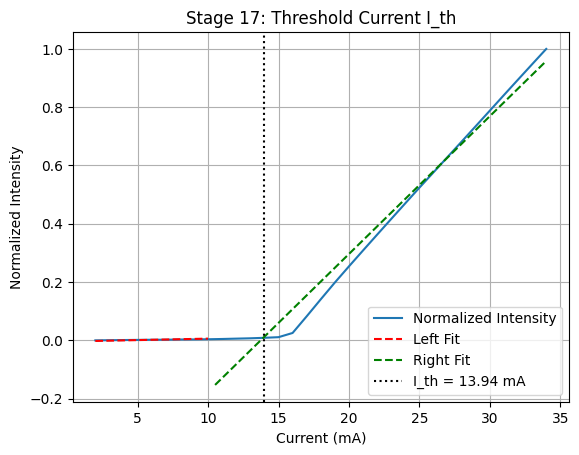

In [28]:
USE_SINGLE_DEVICE = False  # Toggle this to switch modes
WAFER_ID_INPUT = "QCI48"  # Set this to your target wafer ID
TOUCHDOWN_INPUT = 110000  # Set this to your target touchdown number

if USE_SINGLE_DEVICE:
    print("🔍 Extracting one specific device from raw_sweeps_tables...")

    # Find the raw_sweeps table matching the wafer ID
    matching_table = None
    for table in raw_sweeps_tables:
        if table["WAFER_ID"].iloc[0] == WAFER_ID_INPUT:
            matching_table = table
            break

    if matching_table is None:
        raise ValueError(f"❌ No table found with WAFER_ID = {WAFER_ID_INPUT}")

    # Filter the table for the selected TOUCHDOWN
    device_data = matching_table[matching_table["TOUCHDOWN"] == TOUCHDOWN_INPUT]

    if device_data.empty:
        raise ValueError(f"❌ No data found for TOUCHDOWN = {TOUCHDOWN_INPUT} in WAFER_ID = {WAFER_ID_INPUT}")

    # Extract current and intensity (PD) values
    current_mA = device_data["LDI_mA"].values
    intensity = device_data["PD"].values

else:
    print("🔍 Reading sample raw LI data from CSV...")

    SAMPLE_FILE_PATH = ROOT_DIR / "validation" / "SAMPLE_RAW_CURVES.csv"
    df = pd.read_csv(SAMPLE_FILE_PATH, skipinitialspace=True)
    df.columns = df.columns.str.strip()

    current_mA = df["CURRENT_A"].values * 1e3  # Convert from A to mA
    intensity = df["PD_W"].values

# ✅ Common fitting logic
ith = find_ith_value_labview_debug(intensity, current_mA)
print(f"[LabVIEW Method] I_th: {ith:.3f} mA")

ith_prototype = find_ith_value(intensity, current_mA)
print(f"[Prototype Method] I_th: {ith_prototype:.3f} mA")